In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import pdb
import json
from os.path import join as path_join
import cv2
from skimage import measure

In [2]:
# load data
def load_data(path):
    tasks = pd.Series()
    for file_path in os.listdir(path):
        task_file = path_join(path, file_path)
        with open(task_file, 'r') as f:
            task = json.load(f)
        tasks[file_path[:-5]] = task
    return tasks

train_tasks = load_data('../ARC-master/data/training/')

/Users/a18220706/.conda/envs/kaggle-arc/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


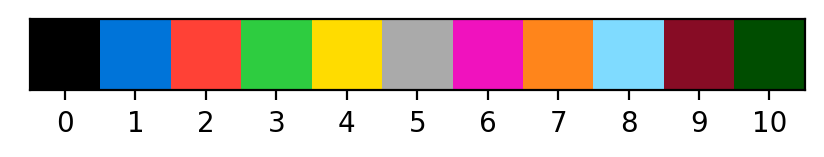

In [3]:
# standardize plotting colors
cmap = colors.ListedColormap(['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
                             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#004d00'])
BACKGROUND_COLOR = 10
norm = colors.Normalize(vmin = 0, vmax = 10)
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
# 10:darkgeen
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(11))], cmap=cmap, norm=norm)
plt.xticks(list(range(11)))
plt.yticks([])
plt.show()
        

task: c8cbb738
running action: add_obj(by_color, all) ActionType.ADD_OBJ (<ObjectDetectionMethod.BY_COLOR: 0>, <TargetObject.ALL: 0>)
running action: sort(size, normal) ActionType.SORT (<ObjectParam.SIZE: 1>, <SortOrder.NORMAL: 0>)
running action: mv_obj(top, down, till_edge) ActionType.MV_OBJ (<TargetObject.TOP: 1>, <MoveDirection.DOWN: 1>, <MoveTarget.TILL_EDGE: 0>)
running action: mv_obj(top, right, till_edge) ActionType.MV_OBJ (<TargetObject.TOP: 1>, <MoveDirection.RIGHT: 2>, <MoveTarget.TILL_EDGE: 0>)
running action: mv_obj(all, to_top_object, centered) ActionType.MV_OBJ (<TargetObject.ALL: 0>, <MoveDirection.TO_TOP_OBJECT: 4>, <MoveTarget.CENTERED: 1>)
move to self.pos [7 7]
move to self.pos [8 6]
move to self.pos [7 6]
move to self.pos [7 6]
running action: resize_grid(cut_to_objects) ActionType.RESIZE_GRID (<ResizeGridType.CUT_TO_OBJECTS: 0>,)
Result correct: True
running action: add_obj(by_color, all) ActionType.ADD_OBJ (<ObjectDetectionMethod.BY_COLOR: 0>, <TargetObject.ALL: 

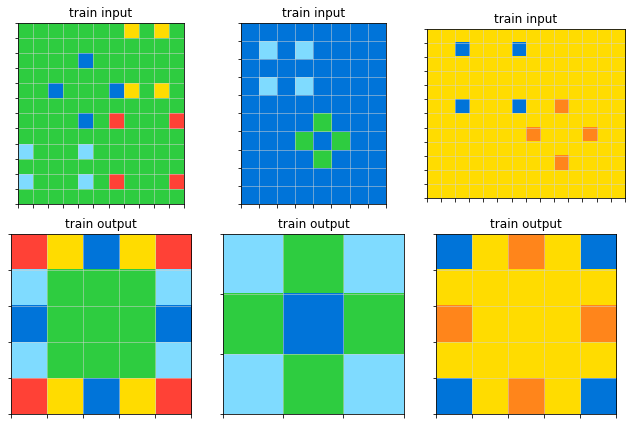

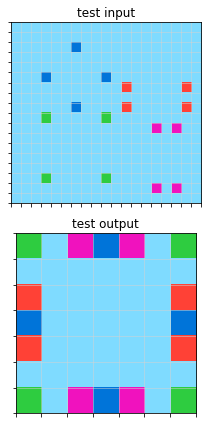

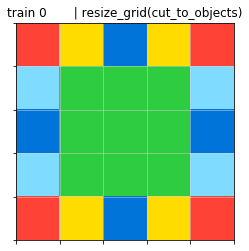

<Figure size 1000x1000 with 0 Axes>

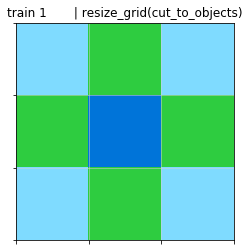

<Figure size 1000x1000 with 0 Axes>

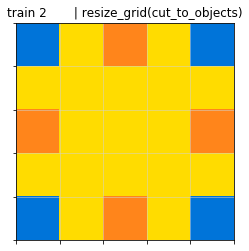

<Figure size 1000x1000 with 0 Axes>

In [6]:
from enum import Enum

class EnumWithNames(Enum):
    
    @classmethod
    def from_str(cls, name):        
        return cls.name_to_val[name]
    
    @classmethod
    def init_enum(cls):
        cls.name_to_val = { value.name.lower(): value for value in cls }

class ObjectDetectionMethod(EnumWithNames):
    BY_COLOR = 0
    BY_ISOLATION = 1
    BY_COLOR_AND_ISOLATION = 2
    
ObjectDetectionMethod.init_enum()
    

class DetectedObject:
    def __init__(self, img, inx, pos):
        self.img = img
        self.inx = inx # the original index of the identified objects (io)
        self.pos = np.array(pos)        
        self.height = img.shape[0] # height of io
        self.width = img.shape[1] # width of io
        self.shape = np.array(img.shape)
        # count of non-background pixels
        self.pixel_count = img[img != BACKGROUND_COLOR].shape[0]
        # overall square cells count
        self.size = img.size
        nc, c = np.unique(img, return_counts = True)
        # number of unique colors
        self.unique_colors = nc
        # the dominating color
        self.color = nc[np.argmax(c)]
        
    # attributes to sort objects
    def attrs(self):
        return {
            'color': self.color,
            'size': self.height * self.width,
            'pos_y': self.pos[0],
            'pos_x': self.pos[1],
            'pixel_count': self.pixel_count,
            'height': self.height,
            'width': self.width
            #TODO: number of shared sides with other objects
        }
        
    def change_color(self, color):
        self.color = color
        self.img[self.img != BACKGROUND_COLOR] = color
        
    def move(self, pos):
        self.pos = pos
        
    def move_till(self, pos, direction):
        if direction == MoveDirection.UP:
            self.pos[0] = pos
        elif direction == MoveDirection.DOWN:
            self.pos[0] = pos - self.height
        elif direction == MoveDirection.LEFT:
            self.pos[1] = pos
        elif direction == MoveDirection.RIGHT:
            self.pos[1] = pos - self.width
        else:
            raise RuntimeError('Wrong MoveDirection')
        
    def move_to(self, obj, target):
        assert target == MoveTarget.CENTERED, 'target should be CENTERED'
        self.pos = (obj.pos + obj.shape / 2 - self.shape / 2).astype(int)
        print('move to self.pos', self.pos)

        
class TargetObject(EnumWithNames):
    ALL = 0
    TOP = 1
    BOTTOM = 2
    
    @staticmethod
    def get_objects(objects, target_object):
        if target_object == TargetObject.ALL:
            return objects
        if target_object == TargetObject.TOP:
            return [objects[-1]]
        if target_object == TargetObject.BOTTOM:
            return [objects[0]]
        raise RuntimeError(f'Wrong target object {target_object}')
    
TargetObject.init_enum()


class MoveDirection(EnumWithNames):
    UP = 0
    DOWN = 1
    RIGHT = 2
    LEFT = 3
    TO_TOP_OBJECT = 4
    
MoveDirection.init_enum()


class MoveTarget(EnumWithNames):
    TILL_EDGE = 0
    CENTERED = 1
    
MoveTarget.init_enum()


class TargetColor(EnumWithNames):
    COLOR0 = 0,
    COLOR1 = 1,
    COLOR2 = 2,
    COLOR3 = 3,
    COLOR4 = 4,
    COLOR5 = 5,
    COLOR6 = 6,
    COLOR7 = 7,
    COLOR8 = 8,
    COLOR9 = 9,
    COLOR10 = 10,
    TOP_OBJECT = 11,
    BOTTOM_OBJECT = 12
    
    @staticmethod
    def to_color(target_color, objects):
        if target_color == TargetColor.TOP_OBJECT:
            return objects[-1].color
        if target_color == TargetColor.BOTTOM_OBJECT:
            return objects[0].color
        return cmap[target_color.value]

TargetColor.init_enum() 


class SortOrder(EnumWithNames):
    NORMAL = 0
    REVERSE = 1

SortOrder.init_enum()


class ObjectParam(EnumWithNames):
    COLOR = 0
    SIZE = 1
    POS_X = 2
    POS_Y = 3
    PIXEL_COUNT = 4
    HEIGHT = 5
    WIDTH = 6
    
ObjectParam.init_enum()


class ResizeGridType(EnumWithNames):
    CUT_TO_OBJECTS = 0
    
ResizeGridType.init_enum()


class Utils:
    @staticmethod
    def crop(img, min, max):
        return img[min[0]:max[0], min[1]:max[1]]
    
    @staticmethod
    def slices(min, max):
        return (slice(min[0],max[0]), slice(min[1],max[1]))
        
class OutputGrid:
    def __init__(self, name, shape, background_color, identified_objects):
        self.name = name
        self.shape = shape
        self.objects = []
        self.background_color = background_color
        self.identified_objects = identified_objects
        
    def increment_name(self, name=None):
        tokens = self.name.split('|')
        if not tokens:
            return
        try:
            index = int(tokens[-1])
        except Exception:
            index = 0
        if name:
            self.name = '|'.join(tokens[:-1]) + ' | ' + name
        else:
            self.name = '|'.join(tokens[:-1]) + ' | ' + str(index + 1)
        
    def add_obj(self, detection_method, target_object):
        assert detection_method in self.identified_objects, f'Wrong detection_method {detection_method}'
        group = self.identified_objects[detection_method]
        objects = TargetObject.get_objects(group, target_object)
        self.objects += objects
        
    def sort(self, attr, sort_order):
        self.objects.sort(key=lambda x: x.attrs()[attr.name.lower()], reverse=(sort_order==SortOrder.REVERSE))
        
    def set_back(self, background_color):
        self.background_color = background_color
        
    def get_target_objects(self, target_object):
        return TargetObject.get_objects(self.objects, target_object)
        
    def set_obj_clr(self, target_object, color):
        objects = self.get_target_objects(target_object)
        for obj in objects:
            obj.change_color(color)
            
    def mv_obj(self, target_object, move_direction, move_target):
        objects = self.get_target_objects(target_object)
        
        for obj in objects:
            self.move_object(obj, move_direction, move_target)
            
    def get_edge(self, direction):
        if direction == MoveDirection.UP:
            return 0
        elif direction == MoveDirection.DOWN:
            return self.shape[0]
        elif direction == MoveDirection.LEFT:
            return 0
        elif direction == MoveDirection.RIGHT:
            return self.shape[1]
        else:
            raise RuntimeError(f'Wrong MoveDirection {direction}')

    def move_object(self, obj, direction, target):
        if direction in { MoveDirection.UP, MoveDirection.DOWN, MoveDirection.LEFT, MoveDirection.RIGHT }:
            assert target == MoveTarget.TILL_EDGE, 'target should be TILL_EDGE'
            obj.move_till(self.get_edge(direction), direction)
        elif direction == MoveDirection.TO_TOP_OBJECT:
            obj.move_to(self.get_target_objects(TargetObject.TOP)[0], target)
        else:
            raise RuntimeError(f'Unknown direction {direction}')
        
    def plot(self):
        img = np.full(self.shape, self.background_color)
        for obj in self.objects:
            # draw only part object inside grid
            delta_min = np.maximum(-obj.pos, np.zeros(2)).astype(int)
            obj_pos = obj.pos + delta_min
            delta_max = np.maximum(obj.pos + obj.shape - self.shape, np.zeros(2)).astype(int)
            obj_img = Utils.crop(obj.img, delta_min, obj.shape - delta_max)
            img_crop = Utils.crop(img, obj_pos, obj_pos + obj_img.shape)
            # not filling background color
            no_back_mask = obj_img != BACKGROUND_COLOR
            img_crop[no_back_mask] = obj_img[no_back_mask]
            img[Utils.slices(obj_pos, obj_pos + obj_img.shape)] = img_crop     
        
        fig, ax = plt.subplots()
        plt.figure(figsize=(5, 5), dpi=200)
        ax.imshow(img, cmap=cmap, norm=norm)
        ax.grid(True, which='both',color='lightgrey', linewidth=0.5)
        ax.set_yticks([x-0.5 for x in range(1+len(img))])
        ax.set_xticks([x-0.5 for x in range(1+len(img[0]))])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(self.name)
        plt.tight_layout()
        plt.show()
        return img
        
    def resize_grid(self, type):
        assert type == ResizeGridType.CUT_TO_OBJECTS, f'Wrong ResizeGridType: {type}'
        delta_min = self.shape
        delta_max = np.zeros(2)
        if not self.objects:
            # no objects, skip resizing grid
            return
        for obj in self.objects:
            delta_min = np.minimum(obj.pos, delta_min).astype(int)
            delta_max = np.maximum(obj.pos + obj.shape, delta_max).astype(int)
        delta_max = np.minimum(self.shape, delta_max).astype(int)
        self.shape = delta_max - delta_min
        assert np.all(self.shape > 0), 'shape should be positive'
        # update objects position
        for obj in self.objects:
            obj.pos -= delta_min


class ActionType(EnumWithNames):
    SET_BACK = 0
    ADD_OBJ = 1
    MV_OBJ = 2
    SET_OBJ_CLR = 3
    SORT = 4
    RESIZE_GRID = 5
    
ActionType.init_enum()


ACTIONS_ARGUMENT_TYPES = {
    ActionType.SET_BACK: (TargetColor, ),
    ActionType.ADD_OBJ: (ObjectDetectionMethod, TargetObject),
    ActionType.MV_OBJ: (TargetObject, MoveDirection, MoveTarget),
    ActionType.SET_OBJ_CLR: (TargetObject, TargetColor),
    ActionType.SORT: (ObjectParam, SortOrder),
    ActionType.RESIZE_GRID: (ResizeGridType, )
}


class Action:
    def __init__(self, type, target):
        self.type = type
        self.target = target
        
    def __call__(self, grid):
        method = getattr(grid, self.type.name.lower())
        method(*self.target)
        
    def __str__(self):
        return f'{self.type} {self.target}'


GENERATOR_VARIANTS = [
    (ActionType.SET_BACK, (0, 1)),
    (ActionType.ADD_OBJ, (1, 1)),
    (ActionType.SORT, (0, 1)),
    (ActionType.MV_OBJ, (0, 1)),
    (ActionType.SORT, (0, 1)),
    (ActionType.SET_OBJ_CLR, (0, 1)),
    (ActionType.RESIZE_GRID, (0, 1))
]


class ArgsGenerator:
    def __init__(self, args_type):
        self.args_type = args_type
        self.args_variants = [[arg_val for arg_val in arg_type] for arg_type in self.args_type]
        
    def __iter__(self):
        self.args = [0 ** len(self.args_type)]
        self.current_root_arg_i = 0
        self.current_variant_i = 0
        return self
    
    def __next__(self):        
        if self.current_variant_i >= len(self.args_variants[self.current_arg_i]):
            self.current_arg_i += 1
            self.current_variant_i = 0
            if self.current_arg_i >= len(self.args_variants):
                raise StopIteration
        self.current_variant_i += 1
        return 


class DSLGenerator:
    def __init__(self, train):
        self.train = train
    
    def generate(self):
        suitable_dsl = []
        for train_pair in self.train:
            input = np.array(train_pair['input'])
            output = np.array(train_pair['output'])
            self.find_suitable_dsl(input, output, suitable_dsl)
            
    # def find_suitable_dsl(self, input, output, suitable_dsl):
    #     if not suitable_dsl:
            
            
            
    def generate_dsl(self, input, output):
        for action_type, count_pair in GENERATOR_VARIANTS:
            args_type = list(ACTIONS_ARGUMENT_TYPES[action_type])
            
        
        
    def apply(self, grid, actions):
        for action in actions:
            action(grid)
        return grid


class ExpressionParser:
    ACTIONS_DELIMITER = ';'
    ARGUMENTS_DELIMITER = ','
    
    def __init__(self, exp):
        self.exp = exp
        self.actions = []
        self.actions_str = []
        self.parse()
        
    def __call__(self, grid, plot_each_action=False):
        assert len(self.actions_str) == len(self.actions), f'{len(self.actions_str)} != {len(self.actions)}'
        for action_str, action in zip(self.actions_str, self.actions):
            print(f'running action: {action_str} {action}')
            action(grid)
            grid.increment_name(action_str)
            if plot_each_action:
                grid.plot()
        
        return grid            
        
    def parse(self):
        actions_str = [x.strip() for x in self.exp.split(self.ACTIONS_DELIMITER)]
        self.actions_str = actions_str
        for action_str in actions_str:
            self.actions.append(self.parse_action(action_str))
        
    def parse_action(self, action_str):
        scope_o = action_str.find('(')
        action_name_str = action_str
        if scope_o != -1:
            action_name_str = action_str[:scope_o].strip()
        action_type = ActionType.from_str(action_name_str)
        
        arg_values = None
        if scope_o != -1:
            scope_c = action_str.find(')', scope_o)
            assert scope_c != -1, "Wrong expression, no closing scope"
            arguments_one_str = action_str[scope_o+1:scope_c]
            arg_values = self.parse_arguments(arguments_one_str, action_type)
        return Action(action_type, arg_values)
                
                
    def parse_arguments(self, arguments_one_str, action_type):
        arguments_str = [x.strip() for x in arguments_one_str.split(self.ARGUMENTS_DELIMITER)]
        assert action_type in ACTIONS_ARGUMENT_TYPES, f'Wrong action type: {action_type}'
        arguments = ACTIONS_ARGUMENT_TYPES[action_type]
        arguments_list = list(arguments)
        assert len(arguments_list) == len(arguments_str),\
            f'Wrong arguments number {len(arguments_list)} != {len(arguments_str)},' \
            f' for action {action_type.name}, arguments_list {arguments_list},' \
            f' arguments_str {arguments_str}'
        arg_values = []
        for arg_type, arg_str in zip(arguments_list, arguments_str):
            arg_value = arg_type.from_str(arg_str)
            arg_values.append(arg_value)
        return tuple(arg_values)
        

class ARCSolver:
    def __init__(self, task_num):
        self.task_num = task_num
        # initialize objects-related things
        self.identified_objects = {}
        
    def reset(self):
        self.identified_objects = {}
        
    
    def plot_one(self, task, ax, i, train_or_test, input_or_output):
        input_matrix = task[train_or_test][i][input_or_output]
        ax.imshow(input_matrix, cmap=cmap, norm=norm)
        ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
        ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
        ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(train_or_test + ' '+input_or_output)
        
    
    def plot_task(self):
        """
        Plots the first train and test pairs of a specified task,
        using same color scheme as the ARC app
        """    
        task = train_tasks[self.task_num]
        name = train_tasks.keys()[self.task_num]
        print('task:', name)
        num_train = len(task['train'])
        fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
        for i in range(num_train):     
            self.plot_one(task, axs[0,i],i,'train','input')
            self.plot_one(task, axs[1,i],i,'train','output')        
        plt.tight_layout()
        plt.show()        
            
        num_test = len(task['test'])
        fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
        if num_test==1: 
            self.plot_one(task, axs[0],0,'test','input')
            self.plot_one(task, axs[1],0,'test','output')     
        else:
            for i in range(num_test):      
                self.plot_one(task, axs[0,i],i,'test','input')
                self.plot_one(task, axs[1,i],i,'test','output')  
        plt.tight_layout()
        plt.show() 
        
    
    def plot_identified_objects(self, identified_objects, title = 'objects'):
        # do not plot anything in the following situations
        if len(identified_objects) == 0:
            print('No objects were identified.')
            return
        # if len(identified_objects) > 10:
        #     print('Way too many objects (>10). Not gonna plot them.')
        #     return
        
        fig, axs = plt.subplots(1, len(identified_objects) + 1, figsize = (8,2))
        for i in range(len(identified_objects) + 1):
            if i == 0:
                axs[0].text(0.5, 0.5, title, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 15)
                axs[0].get_xaxis().set_visible(False)
                axs[0].get_yaxis().set_visible(False)
                axs[0].axis('off')
            else:
                obj = identified_objects[i-1]
                axs[i].imshow(obj.img, cmap = cmap, norm = norm)
                axs[i].axis('off')
                axs[i].set_title('object{}'.format(i))
        plt.tight_layout()
        plt.show()
    
    
    @staticmethod
    def get_background(image):
        # if image contains 0 
        if 0 in image:
          background = 0
        # else use the most frequent pixel color
        else: 
          unique_colors, counts = np.unique(image, return_counts=True)
          background = unique_colors[np.argmax(counts)]
        return background
    
    
    def check_pairs(self, inx_pairs, this_pair, return_inx = False):
        # check if this_pair is in inx_pairs
        match = []
        for pair in inx_pairs:
          if pair[0] == this_pair[0] and pair[1] == this_pair[1]:
            match.append(True)
          else:
            match.append(False)
        if return_inx:
          return any(match), np.where(match)
        else:
          return any(match)
    
    
    def check_neighbors(self, all_pairs, this_pair, objectness, this_object):
        # all_pairs: an array of index pairs for all nonzero/colored pixels
        # this_pair: the index pair whose neighbors will be checked
        # objectness: an array with the shape of original image, storage for how much objectness has been identified
        # this_object: the current object we are looking at
        row_inx = this_pair[0]
        col_inx = this_pair[1]
        objectness[row_inx, col_inx] = this_object
        # find if any neighboring pixels contain color
        if self.check_pairs(all_pairs, [row_inx-1, col_inx-1]): # up-left
          objectness[row_inx-1, col_inx-1] = this_object
        if self.check_pairs(all_pairs, [row_inx-1, col_inx]): # up
          objectness[row_inx-1, col_inx] = this_object 
        if self.check_pairs(all_pairs, [row_inx-1, col_inx+1]): # up-right
          objectness[row_inx-1, col_inx+1] = this_object
        if self.check_pairs(all_pairs, [row_inx, col_inx-1]): # left
          objectness[row_inx, col_inx-1] = this_object
        if self.check_pairs(all_pairs, [row_inx, col_inx+1]): # right
          objectness[row_inx, col_inx+1] = this_object
        if self.check_pairs(all_pairs, [row_inx+1, col_inx-1]): # down-left
          objectness[row_inx+1, col_inx-1] = this_object
        if self.check_pairs(all_pairs, [row_inx+1, col_inx]): # down
          objectness[row_inx+1, col_inx] = this_object
        if self.check_pairs(all_pairs, [row_inx+1, col_inx+1]): # down-right
          objectness[row_inx+1, col_inx+1] = this_object
        return objectness
    
    
    def identify_object_by_color(self, true_image, background = 0):
        # identify object by the color only 
        unique_colors = np.unique(true_image)
        identified_objects = []
        for i, color in enumerate(unique_colors):
          image = np.copy(true_image) # make a copy from original first
          if color == background: 
            continue
          image[image != color] = BACKGROUND_COLOR
          inx = np.where(image == color)
          pos = np.min(inx[0]), np.min(inx[1])
          img = image[np.min(inx[0]):np.max(inx[0])+1, np.min(inx[1]):np.max(inx[1])+1]
          obj = DetectedObject(img, len(identified_objects), pos)
          # append the object attributes
          identified_objects.append(obj)
        return identified_objects
    
    
    def identify_object_by_isolation(self, image, background = 0):
        # identify all objects by physical isolation on the given image
        all_pairs = np.array(np.where(image != background)).T
        objectness = np.zeros(image.shape)
        identified_objects = []
        this_object = 1
        while len(all_pairs) >= 1:
          init_pair = all_pairs[0] # start with the first pair
          objectness = self.check_neighbors(all_pairs, init_pair, objectness, this_object)
          # get a list of index pairs whose neghbors haven't been checked
          unchecked_pairs = np.array(np.where(objectness == this_object)).T
          checked_pairs = np.zeros((0,2)) 
          # check all the index pairs in the expanding unchecked_pairs untill all have been checked
          while len(unchecked_pairs) != 0:
            this_pair = unchecked_pairs[0]
            objectness = self.check_neighbors(all_pairs, this_pair, objectness, this_object)
            # append the checked_pairs
            checked_pairs = np.vstack((checked_pairs, this_pair))
            # get all index pairs for the currently identified object
            current_object_pairs = np.array(np.where(objectness == this_object)).T
            # delete the checked pairs from current object pairs
            checked_inx = []
            for pair in checked_pairs:
              _, inx = self.check_pairs(current_object_pairs, pair, return_inx = True)
              checked_inx.append(inx[0][0])
            unchecked_pairs = np.delete(current_object_pairs, checked_inx, axis = 0)
    
          # store this object to identified_objects
          current_object_pairs = np.array(np.where(objectness == this_object)).T
          cop = current_object_pairs.T
          pos = np.min(cop[0]), np.min(cop[1])
          img = image[np.min(cop[0]):np.max(cop[0])+1, np.min(cop[1]):np.max(cop[1])+1]
          img[img == background] = BACKGROUND_COLOR
          # delete the current object pairs from all_pairs 
          cop_inx = []
          for pair in current_object_pairs:
            _, this_cop_inx = self.check_pairs(all_pairs, pair, return_inx = True)
            cop_inx.append(this_cop_inx[0][0])
          all_pairs = np.delete(all_pairs, cop_inx, axis = 0)
          # append the object attributes
          obj = DetectedObject(img, len(identified_objects), pos)
          identified_objects.append(obj)          
          # start identifying a new object
          this_object += 1
        return identified_objects
    
    
    def identify_object_by_color_isolation(self, true_image, background = 0):
        # identify objects first by color then by physical isolation
        unique_colors = np.unique(true_image)
        for i, color in enumerate(unique_colors):
          image = np.copy(true_image) # make a copy from the original first
          if color == background:
            continue
          # identify objects by isolation in this color only 
          image[image != color] = BACKGROUND_COLOR
          return self.identify_object_by_isolation(image, background = BACKGROUND_COLOR)
    
    
    def identify_object(self, image, method):
        # a wrapper of different methods
        # in the future method can be a parameter to be learned
        # 1 = by_color, 2 = by_isolation, 3 = by_color_isolation
        background = self.get_background(image)
        res = None
        if method == ObjectDetectionMethod.BY_COLOR:
            res = self.identify_object_by_color(image, background)
        elif method == ObjectDetectionMethod.BY_ISOLATION:
            res = self.identify_object_by_isolation(image, background)
        elif method == ObjectDetectionMethod.BY_COLOR_AND_ISOLATION:
            res = self.identify_object_by_color_isolation(image, background)
        else:
            raise RuntimeError('Wrong ObjectDetectionMethod')
        self.identified_objects[method] = res
        
        
    # def solve(self):
    #     self.plot_task()
    #     # select an image for object identification
    #     # WE USE TRAIN INPUT
    #     image = np.array(train_tasks[task_num]['train'][0]['input'])
    #     background = self.get_background(image)
    # 
    #     for object_detection_method in ObjectDetectionMethod:
    #         self.identify_object(image, object_detection_method)
    #         self.plot_identified_objects(arc.identified_objects[object_detection_method], title = object_detection_method.name)
    #         
    #     grid0 = OutputGrid('grid 0', image.shape, background)
    #     for obj in self.identified_objects[ObjectDetectionMethod.BY_COLOR]:
    #         grid0.add_obj(obj)
    #     grid0.plot()
    #     
    #     exp_example = "add_obj(all); mv_obj(all, down, till_edge); mv_obj(all, right, till_edge)"
    # 
    #     expression = ExpressionParser(exp_example)
    #     expression()



# randomly select 20 task numbers
TASK_NUM = np.random.randint(1,400, size = 20)
TASK_NUM = [1]
for task_num in TASK_NUM:
    arc = ARCSolver(task_num)
    
    arc.plot_task()
    
    exp_example = "add_obj(by_color, all); sort(size, normal); mv_obj(top, down, till_edge); " \
                  "mv_obj(top, right, till_edge); mv_obj(all, to_top_object, centered);" \
                  "resize_grid(cut_to_objects)"
    expression = ExpressionParser(exp_example)
    
    
    for train_i, train_input in enumerate(train_tasks[task_num]['train']):
    
        # select an image for object identification
        image = np.array(train_input['input'])
        background = arc.get_background(image)
    
        for object_detection_method in ObjectDetectionMethod:
            arc.identify_object(image, object_detection_method)
            # arc.plot_identified_objects(arc.identified_objects[object_detection_method], title = object_detection_method.name)
            
        grid0 = OutputGrid(f'train {train_i} | start', image.shape, background, arc.identified_objects)
        
        grid1 = expression(grid0, plot_each_action=False)
        res_img = grid1.plot()
        res_correct = np.all(res_img == train_input['output'])
        print('Result correct:', res_correct)

In [7]:
image = np.array(train_tasks[0]['train'][0]['input'])


In [33]:
a = np.array([[1, 3],[2, 3]])
a

array([[1, 3],
       [2, 3]])

In [51]:
a = np.diag((1, 2, 3))
a


array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [56]:
a[((0,2), 1)]

array([0, 0])

In [62]:
slice(1,4)

slice(1, 4, None)

In [11]:
MoveDirection(0)

<MoveDirection.UP: 0>